# Modelling

## Notebook Summary


Linear Model Implementation

## Notebook Setup

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Loading sklearn functionality
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif, f_regression

# Set global random seed for reproducibility
random_seed_val = 42
np.random.seed(random_seed_val)

## Data Loading & Understanding

In [2]:
# Creating DataFrame
pp_house_df = pd.read_csv("london_house_price_data_pp.csv")
# Viewing DataFrame
pp_house_df.head(5)

,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,saleEstimate_currentPrice,history_price,tenure_Feudal,tenure_Freehold,...,propertyType_Mid Terrace House,propertyType_Mid Terrace Property,propertyType_Purpose Built Flat,propertyType_Semi-Detached Bungalow,propertyType_Semi-Detached House,propertyType_Semi-Detached Property,propertyType_Terrace Property,propertyType_Terraced,propertyType_Terraced Bungalow,currentEnergyRating_encoded
0,51.495505,-0.132379,2.0,2.0,71.0,1.0,759000.0,249950,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,51.478185,-0.092201,1.0,1.0,64.0,1.0,388000.0,32000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,51.588774,-0.139599,1.0,4.0,137.0,2.0,1261000.0,133000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,51.466089,0.006967,1.0,2.0,97.0,1.0,944000.0,128500,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,51.451327,-0.007569,1.0,3.0,135.0,2.0,726000.0,75000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0


In [3]:
# Columns and data types
pp_house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265911 entries, 0 to 265910
Data columns (total 32 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   latitude                             265911 non-null  float64
 1   longitude                            265911 non-null  float64
 2   bathrooms                            265911 non-null  float64
 3   bedrooms                             265911 non-null  float64
 4   floorAreaSqM                         265911 non-null  float64
 5   livingRooms                          265911 non-null  float64
 6   saleEstimate_currentPrice            265911 non-null  float64
 7   history_price                        265911 non-null  int64  
 8   tenure_Feudal                        265911 non-null  float64
 9   tenure_Freehold                      265911 non-null  float64
 10  tenure_Leasehold                     265911 non-null  float64
 11  tenure_Shared

In [4]:
# Shape of the DataFrame
pp_house_df.shape

(265911, 32)

## Preparing Data

In [5]:
# Seperating features from target
X = pp_house_df.drop('saleEstimate_currentPrice', axis=1)
y = pp_house_df['saleEstimate_currentPrice']

In [6]:
# Remainder test split
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.20, random_state=random_seed_val)

# Train validation split
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size=0.20, random_state=random_seed_val)

# Checking size of split
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}") 
print(f"Test set size: {len(X_test)}")

Training set size: 170182
Validation set size: 42546
Test set size: 53183


## Linear Modelling

Implementation of predicitive models which assume that only linear relationships exist between the target and the features.

### Linear Regression 

The performance of this simple linear model will be used as a baseline for future linear models for comparison. Default hyperparameters used, no tuning required.

In [10]:
# Defining model
lin_reg_model = LinearRegression()

# Fitting model
lin_reg_model.fit(X_train, y_train)

# Scoring on train
train_score = lin_reg_model.score(X_train, y_train)

# Scoring on validation
valid_score = lin_reg_model.score(X_valid, y_valid)

# Print performance
print(f"The R^2 value for the training set is {train_score} and the R^2 value for the validation set is {valid_score}")


The R^2 value for the training set is 0.7404895370629878 and the R^2 value for the validation set is 0.7254400486265812


**Model Performance**

The close alignment between the training and validation R^2 scores suggests that the model generalizes effectively to unseen data without overfitting. The R^2 values indicate that the model explains around 74% of the variance in the target variable, the model captures a significant portion of the underlying patterns in the data. 

In [8]:
# Coefficients
lin_reg_model.coef_

# Coefficient and Feature DataFrame
coeff_df = pd.DataFrame(lin_reg_model.coef_, index=X_train.columns, columns = ["coeffeicent"] )

# Reset index to turn the index into a column
coeff_df.reset_index(inplace=True)

# Rename columns appropriately
coeff_df.columns = ['Feature', 'Coefficient']

# Display DataFrame
print(coeff_df)

                                Feature    Coefficient
0                              latitude  -77284.354152
1                             longitude -964545.531122
2                             bathrooms  183294.003060
3                              bedrooms  -95235.818285
4                          floorAreaSqM    7935.101099
5                           livingRooms   42299.976594
6                         history_price       0.349616
7                         tenure_Feudal   32229.066267
8                       tenure_Freehold -198898.527433
9                      tenure_Leasehold   14429.177622
10                        tenure_Shared  152240.283805
11       propertyType_Bungalow Property   29668.457867
12          propertyType_Converted Flat -129411.734558
13       propertyType_Detached Bungalow  -42511.675132
14          propertyType_Detached House   13739.428985
15       propertyType_Detached Property -132754.492073
16    propertyType_End Terrace Bungalow   85676.828067
17       p

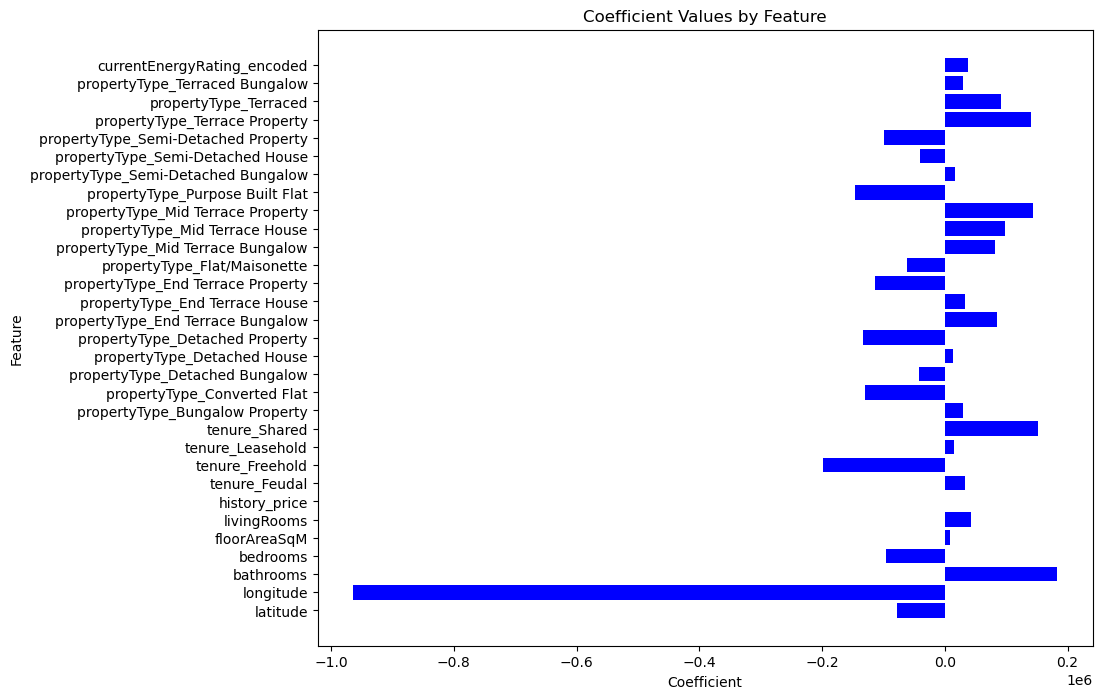

In [ ]:
# Create a bar chart
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
plt.barh(coeff_df['Feature'], coeff_df['Coefficient'], color='blue')  # Horizontal bar chart
plt.xlabel('Coefficient') 
plt.ylabel('Feature')  
plt.title('Coefficient Values by Feature')  
plt.show()  


**Interpretation of Coefficients**

**LOCATION**

- *Latitude:* Negative coefficient suggests properties further north are less expensive.

- *Longitude:* Strong negative coefficient indicates properties further east are significantly cheaper, possibly highlighting the desirability of western regions.

Location strongly influences prices, but the abnormally large magnitude of longitude may indicate scaling issues or outliers.

**PROPERTY CHARACTERISTICS**

- *Bathrooms:* Positive coefficient; more bathrooms increase price.

- *Bedrooms:* Negative coefficient (counterintuitive); may indicate multicollinearity or data issues.

- *Floor Area (floorAreaSqM):* Positive coefficient; larger properties are more expensive.

- *Living Rooms:* Positive coefficient; more living rooms increase price.

Most features align with expectations, but the negative bedrooms coefficient is unusual and warrants investigation.

**PRICE HISTORY**

- *History Price:* Very small coefficient; historical prices have minimal impact on current prices.

- *Takeaway:* Past prices are not a strong predictor of current property values.

**TENURE TYPE**

- *Freehold:* Strong negative coefficient (counterintuitive); contradicts typical real estate trends.

- *Shared Ownership:* Positive coefficient; shared ownership properties are more expensive.

The negative Freehold coefficient is unexpected and may indicate data issues or confounding factors.

**PROPERTY TYPE** 

- *Purpose Built Flat:* Strong negative coefficient; these properties are significantly cheaper.

- *Mid Terrace Property:* Strong positive coefficient; these properties are more expensive.

- *Semi-Detached House:* Negative coefficient; contradicts typical market trends.

Property type has mixed effects, with some coefficients aligning with expectations and others showing anomalies.

**ENERGY RATING** 

- *Current Energy Rating:* Positive coefficient; higher energy ratings increase property prices.

Energy efficiency is valued in the market, aligning with sustainability trends.

**Key Insights**

The model mostly captures expected trends but shows anomalies such as bedrooms, Freehold, Semi-Detached House, Purpose Built Flat. 

More bedrooms typically elevate property prices however, the model unexpectedly indicates the opposite. Generally, freehold properties command higher values compared to leasehold or feudal ones but the alternative is suggested by a strong negative coefficient. Semi-detached houses are also unexpectedly associated with a negative coefficient, when they are usually priced above terraced homes or flats. Although flats tend to be more affordable, the size of the coefficient associated with them is unusually large.Additionally, the extremely large negative coefficient for longitude indicates an unusually high influence

These anomalous results may stem from multicollinearity, data quality issues, or model limitations. Further refinement, such as scaling or regularization must be performed to improve accuracy and interpretability.




## Ridge Regression

Implementing Ridge regression with varying values for alpha, to tune hyperparameter. Examining which values of alpha show the best performance on the model.

In [10]:
alpha_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
ridge_train_score = []
ridge_valid_score = []

for alpha in alpha_values:
    # Instantiate model with alpha value
    ridge_model = Ridge(alpha=alpha)

    # Fit model
    ridge_model.fit(X_train, y_train)

    # Scores
    train_score_val = ridge_model.score(X_train, y_train)
    valid_score_val = ridge_model.score(X_valid, y_valid)

    # Storing
    ridge_train_score.append(train_score_val)
    ridge_valid_score.append(valid_score_val)



c:\Users\sanja\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.68079e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\sanja\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.68077e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\sanja\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.68057e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\sanja\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.67866e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\sanja\anaconda3\env

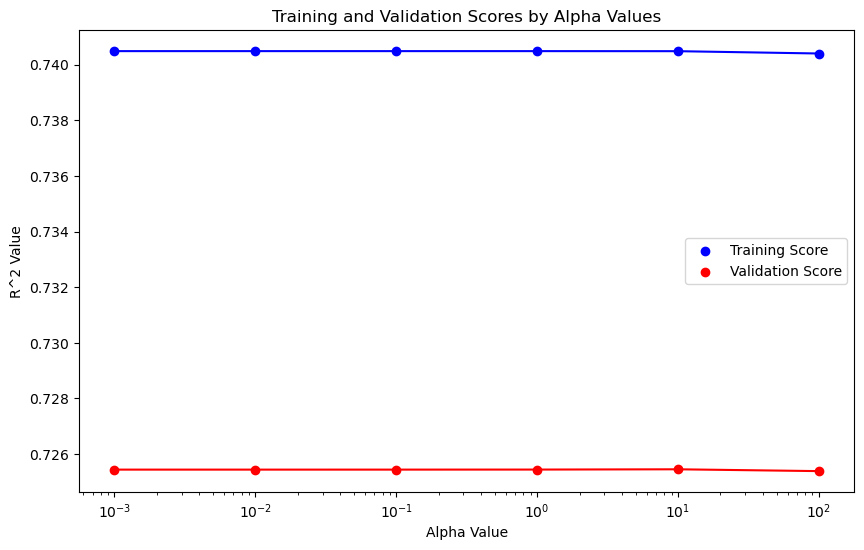

In [11]:
# Plotting scores against alpha

# Creating scatter plot with two lines
plt.figure(figsize=(10, 6))
plt.scatter(alpha_values, ridge_train_score, color='blue', label='Training Score')
plt.scatter(alpha_values, ridge_valid_score, color='red', label='Validation Score')
plt.plot(alpha_values, ridge_train_score, color='blue')
plt.plot(alpha_values, ridge_valid_score, color='red')

# Logarithmic scale for the x-axis
plt.xscale('log')

# Labels and Title
plt.xlabel('Alpha Value')
plt.ylabel('R^2 Value')
plt.title('Training and Validation Scores by Alpha Values')
plt.legend()

# Show plot
plt.show()
